# Differentiating Good and Bad at low level data

### GoodDataQuality.root 009-230-001 and 009-230-002

DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&(0x4))!=0

### BadDataQuality.root 009-230-001 to 009-230-009

(DataQuality[0]!=0 | DataQuality[1]!=0 | DataQuality[2]!=0 | DataQuality[3]!=0 ) && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&(0x4))!=0

### TestDataQuality.root 009-230-010 and 009-230-011
CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&(0x4))!=0

### Good_dual_gate.root 009-230-001 adn 009-230-002
DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && ((TriggerCounter[33]|TriggerCounter[36])&(0x4))!=0
### Bad_dual_gate.root 009-230-010 to 009-230-019
(DataQuality[0]!=0 | DataQuality[1]!=0 | DataQuality[2]!=0 | DataQuality[3]!=0) && ((TriggerCounter[33]|TriggerCounter[36])&(0x4))!=0
###


# Definations and python imports



In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from root_pandas import read_root
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 10.0, 8.0

file_good = "Good_dual_gate.root"
file_bad = "Bad_dual_gate.root"

data = "PMTALL"
tree = "tree"

pmt_all_length = 4480

def NORM(file, tree, data):
    pmtall = read_root(file, tree, columns=[data],flatten=[data])
    num_entries, w = pmtall.shape
    num_entries = int(num_entries/pmt_all_length)
    x = pmtall.PMTALL.values.reshape(num_entries, pmt_all_length)
    x_abs = abs(x - 15200)
    extra = np.arange(4160, pmt_all_length)
    x_mod = np.delete(x_abs, extra, axis=1)
#     x_nor = normalize(x_mod, norm="l1")
    return x_mod

def differ(x,y):
    for i in range(len(x)):
        x[i] = x[i] - y
    return x

def sep(x, ratio_1, ratio_2, ratio_3, group):
    train = np.zeros((int(len(x)*ratio_1), len(x[0])))
    validation = np.zeros((int(len(x)*ratio_2),len(x[0])))
    test = np.zeros((int(len(x)*ratio_3), len(x[0])))
    for i in range(len(x)):
        if i < int(len(x)*ratio_1):
            train[i] = x[i]
            
        if i >= int(len(x)*ratio_1) and i < int(len(x)*(ratio_2 +ratio_1)):
            k = i - int(len(x)*ratio_1) - 1
            validation[k] = x[i]
            
        if i >= int(len(x)*(ratio_1 + ratio_2)):
            p = i - int(len(x)*(ratio_1 + ratio_2)) - 1
            test[p] = x[i]
        
    train_label = np.zeros(len(train))
    validation_label = np.zeros(len(validation))
    test_label = np.zeros(len(test))
    for i in range(len(train)):
        train_label[i] = group
    for i in range(len(validation)):
        validation_label[i] = group
    for i in range(len(test)):
        test_label[i] = group
    return train, validation, test, train_label, validation_label, test_label

import keras
def data_for_cnn(x1, x2, group):
    x11, x12, x13, x14, x15, x16 = x1
    x21, x22, x23, x24, x25, x26 = x2
#     x31, x32, x33, x34, x35, x36 = x3
#     x41, x42, x43, x44, x45, x46 = x4
#     x51, x52, x53, x54, x55, x56 = x5
#     x61, x62, x63, x64, x65, x66 = x6
    y1 = np.concatenate((x11, x21), axis=0)
    y2 = np.concatenate((x12, x22), axis=0)
    y3 = np.concatenate((x13, x23), axis=0)
    y4 = np.concatenate((x14, x24), axis=0)
    y5 = np.concatenate((x15, x25), axis=0)
    y6 = np.concatenate((x16, x26), axis=0)
    z1 = np.expand_dims(y1, axis=2)
    z2 = np.expand_dims(y2, axis=2)
    z3 = np.expand_dims(y3, axis=2)
    z4 = keras.utils.to_categorical(y4, group)
    z5 = keras.utils.to_categorical(y5, group)
    z6 = keras.utils.to_categorical(y6, group)
    return z1, z2, z3, z4, z5, z6

Welcome to JupyROOT 6.10/08


Using TensorFlow backend.
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


CPU times: user 1.54 s, sys: 573 ms, total: 2.12 s
Wall time: 2.6 s


In [2]:
%%time

ratio_1 = 0.6
ratio_2 = 0.2
ratio_3 = 0.2

print("Number of entries")

PMTALL_good = NORM(file_good, tree, data)
print("Good :",len(PMTALL_good))
good = sep(PMTALL_good, ratio_1, ratio_2, ratio_3, 0)
del PMTALL_good

PMTALL_bad = NORM(file_bad, tree, data)
print("Bad :",len(PMTALL_bad))
bad = sep(PMTALL_bad, ratio_1, ratio_2, ratio_3, 1)
del PMTALL_bad

classes = 2
train_data, validation_data, test_data, train_label, validation_label, test_label = data_for_cnn(good, bad, classes)

del good, bad

Number of entries
Good : 41852
Bad : 34554
CPU times: user 19.1 s, sys: 4.82 s, total: 23.9 s
Wall time: 23.9 s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4145, 16)          272       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2072, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2057, 32)          8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 514, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 514, 64)           2112      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Epoch 44/50
45843/45843 [==============================] - 160s 3ms/step - loss: 0.0710 - acc: 0.9732 - val_loss: 0.0505 - val_acc: 0.9822
Epoch 45/50
45843/45843 [==============================] - 171s 4ms/step - loss: 0.0677 - acc: 0.9748 - val_loss: 0.0874 - val_acc: 0.9670
Epoch 46/50
45843/45843 [==============================] - 172s 4ms/step - loss: 0.0669 - acc: 0.9758 - val_loss: 0.0553 - val_acc: 0.9827
Epoch 47/50
45843/45843 [==============================] - 172s 4ms/step - loss: 0.0708 - acc: 0.9733 - val_loss: 0.2117 - val_acc: 0.9145
Epoch 48/50
45843/45843 [==============================] - 178s 4ms/step - loss: 0.0687 - acc: 0.9747 - val_loss: 0.0558 - val_acc: 0.9810
Epoch 49/50
45843/45843 [==============================] - 180s 4ms/step - loss: 0.0701 - acc: 0.9741 - val_loss: 0.0673 - val_acc: 0.9757
Epoch 50/50
45843/45843 [==============================] - 187s 4ms/step - loss: 0.0673 - acc: 0.9749 - val_loss: 0.0621 - val_acc: 0.9796
Test loss: 0.0552875529161


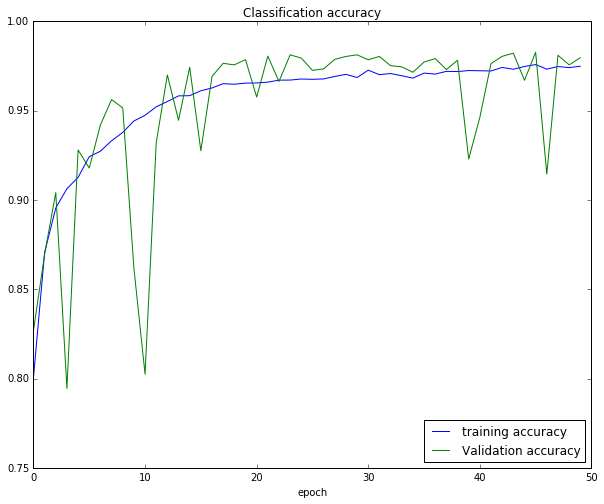

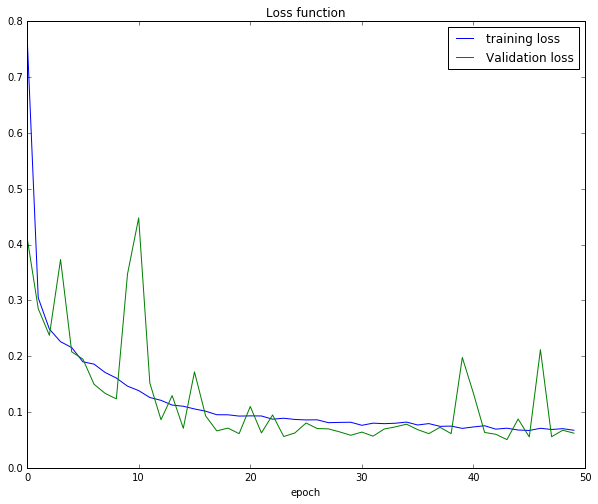

Classification accuracy = 0.979646603787
CPU times: user 13h 27min 5s, sys: 1h 4min 15s, total: 14h 31min 21s
Wall time: 2h 25min 19s


2017-12-13 21:22:19.464400: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [3]:
%%time
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization, Embedding, LSTM

from keras.regularizers import l2
from keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(16, kernel_size=16, activation="relu", input_shape=(len(train_data[0]),1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 16, activation="relu"))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(64, 1, activation="relu"))
model.add(MaxPooling1D(pool_size=8))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
# model.add(Dense(32,activation="relu"))
# model.add(Dense(16,activation="relu"))
# model.add(Dense(8,activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(classes,activation="softmax"))
model.summary()
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
history = model.fit(train_data, train_label, batch_size=200, epochs=50, verbose=1, validation_data=(validation_data, validation_label))
score = model.evaluate(test_data, test_label, verbose=0)
model.save("CNN_good_bad.h5")

del train_data,train_label,validation_data,validation_label,test_data,test_label

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])